In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras import models
import tensorflow as tf
import tensorboard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-03-08 03:02:06.598057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 03:02:06.714399: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 03:02:07.137426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/bjbae/miniconda3/envs/ml/lib/
2023-03-08 03:02:07.140338: W tensorflow/compiler/xla/stream_

Num GPUs Available:  1


2023-03-08 03:02:07.913051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 03:02:07.932063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 03:02:07.932364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# load dataset
# encoding error with degrees symbol in utf-8
df = pd.read_csv("./SeoulBikeData.csv",
                 encoding_errors="ignore")

# data cleaning removing measurement labels
rename_dict = {}
rename_dict["Temperature(C)"] = "Temperature"
rename_dict["Humidity(%)"] = "Humidity"
rename_dict["Wind speed (m/s)"] = "Wind speed"
rename_dict["Visibility (10m)"] = "Visibility"
rename_dict["Dew point temperature(C)"] = "Dew point temperature"
rename_dict["Solar Radiation (MJ/m2)"] = "Solar Radiation"
rename_dict["Rainfall(mm)"] = "Rainfall"
rename_dict["Snowfall (cm)"] = "Snowfall"
df.rename(columns=rename_dict, inplace=True)

In [3]:
# Predict Rented Bike Count
# Predictors Hour, Temp, Hum, Solar Rad, Rain, Snow, Seasons, Holiday
# Filter Functional Day (Times where bike sharing was unavailible)

# print(df.columns)
# print(df.describe())
# print(df["Functioning Day"].describe())
# print(df.shape)

# df_EDA = df.loc[df["Functioning Day"] != "Yes", :]
# print(df_EDA)

In [4]:
# First filter valid rows
df_filtered = df.loc[df["Functioning Day"] == "Yes", :]

# Create Predicted and Predictors
X = df_filtered.iloc[:, 2:13]
y = df_filtered.loc[:, "Rented Bike Count"]

# Encode values in X
X = pd.get_dummies(X, drop_first=True)
X = pd.get_dummies(X, columns=["Hour"], drop_first=True)
print(X.columns)

Index(['Temperature', 'Humidity', 'Wind speed', 'Visibility',
       'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall',
       'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'Holiday_No Holiday', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5',
       'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')


In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=22)

std = StandardScaler()
ct = ColumnTransformer([
    ('std', StandardScaler(), list(rename_dict.values()))
], remainder='passthrough')
ct.fit_transform(X_train, y_test)
ct.transform(X_test)
print(X_train.head())
print(X_train.describe())

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

      Temperature  Humidity  Wind speed  Visibility  Dew point temperature  \
5591         28.8        56         1.6        2000                   19.1   
5990         34.0        50         1.2        1744                   22.1   
4563         19.1        84         0.6         421                   16.3   
7837         13.5        82         0.8         962                   10.4   
3109         12.4        32         1.7        1441                   -3.8   

      Solar Radiation  Rainfall  Snowfall  Seasons_Spring  Seasons_Summer  \
5591             0.00       0.0       0.0               0               1   
5990             1.68       0.0       0.0               0               1   
4563             0.00       0.0       0.0               0               1   
7837             1.33       0.0       0.0               0               0   
3109             3.06       0.0       0.0               1               0   

      ...  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  Hour_19  Hou

In [6]:
num_epochs = 20

## Model 1

In [7]:
# Create the model

model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 288       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


2023-03-08 03:02:08.040038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 03:02:08.042921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 03:02:08.043401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 03:02:08.043668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=1, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20


2023-03-08 03:02:10.572814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 03:02:10.589544: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f007bc3a8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 03:02:10.589581: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-08 03:02:10.595228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 03:02:10.945562: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-08 03:02:10.998917: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most on

5925/5925 [==============================] - 51s 8ms/step - loss: 419087.0000 - mae: 483.2703 - val_loss: 398278.6250 - val_mae: 434.7032
Epoch 2/20
5925/5925 [==============================] - 20s 3ms/step - loss: 320432.8750 - mae: 422.3796 - val_loss: 362796.7500 - val_mae: 415.5842
Epoch 3/20
5925/5925 [==============================] - 19s 3ms/step - loss: 297693.4688 - mae: 400.0399 - val_loss: 479020.3438 - val_mae: 494.7940
Epoch 4/20
5925/5925 [==============================] - 20s 3ms/step - loss: 286565.6250 - mae: 393.5294 - val_loss: 402107.5938 - val_mae: 440.5530
Epoch 5/20
5925/5925 [==============================] - 20s 3ms/step - loss: 274316.0938 - mae: 384.7775 - val_loss: 289966.5000 - val_mae: 374.7168
Epoch 6/20
5925/5925 [==============================] - 20s 3ms/step - loss: 267586.3125 - mae: 376.7096 - val_loss: 366424.0000 - val_mae: 410.7064
Epoch 7/20
5925/5925 [==============================] - 19s 3ms/step - loss: 259924.8438 - mae: 370.8067 - val_loss: 

[203430.6875, 309.9462585449219]

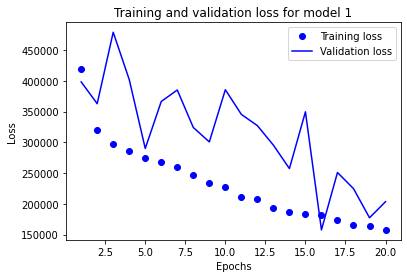

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model1.png', dpi=1200)

plt.show()

## Model 2

In [10]:
model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 288       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=10, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
593/593 [==============================] - 4s 6ms/step - loss: 447672.4375 - mae: 503.8513 - val_loss: 443985.9375 - val_mae: 476.5251
Epoch 2/20
593/593 [==============================] - 2s 4ms/step - loss: 375851.7188 - mae: 468.7412 - val_loss: 365869.3438 - val_mae: 428.9263
Epoch 3/20
593/593 [==============================] - 2s 4ms/step - loss: 339572.3125 - mae: 440.7800 - val_loss: 361689.8750 - val_mae: 416.8912
Epoch 4/20
593/593 [==============================] - 2s 4ms/step - loss: 317797.6250 - mae: 421.8239 - val_loss: 321769.4375 - val_mae: 398.9556
Epoch 5/20
593/593 [==============================] - 2s 4ms/step - loss: 304895.0000 - mae: 409.8653 - val_loss: 391099.2812 - val_mae: 425.8561
Epoch 6/20
593/593 [==============================] - 2s 3ms/step - loss: 294221.0625 - mae: 399.9736 - val_loss: 338278.7812 - val_mae: 398.4725
Epoch 7/20
593/593 [==============================] - 2s 4ms/step - loss: 288812.2500 - mae: 393.0206 - val_loss: 344773.906

[274187.15625, 345.5307922363281]

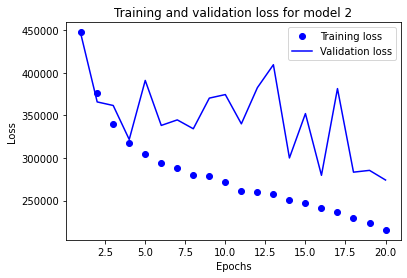

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model2.png', dpi=1200)

plt.show()

## Model 3

In [13]:
model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 288       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 2s 6ms/step - loss: 731233.1250 - mae: 633.9987 - val_loss: 441436.0312 - val_mae: 490.5400
Epoch 2/20
297/297 [==============================] - 1s 5ms/step - loss: 463668.8438 - mae: 513.7659 - val_loss: 434511.4688 - val_mae: 475.8033
Epoch 3/20
297/297 [==============================] - 2s 5ms/step - loss: 417305.7188 - mae: 490.6623 - val_loss: 416950.8125 - val_mae: 465.0143
Epoch 4/20
297/297 [==============================] - 1s 4ms/step - loss: 400328.4062 - mae: 478.3133 - val_loss: 401610.3438 - val_mae: 454.4896
Epoch 5/20
297/297 [==============================] - 1s 5ms/step - loss: 382883.1875 - mae: 470.1590 - val_loss: 381388.5938 - val_mae: 439.4857
Epoch 6/20
297/297 [==============================] - 1s 4ms/step - loss: 361960.5938 - mae: 459.6268 - val_loss: 367064.2500 - val_mae: 429.8008
Epoch 7/20
297/297 [==============================] - 1s 4ms/step - loss: 355912.9062 - mae: 450.2488 - val_loss: 362970.343

[337777.625, 396.9545593261719]

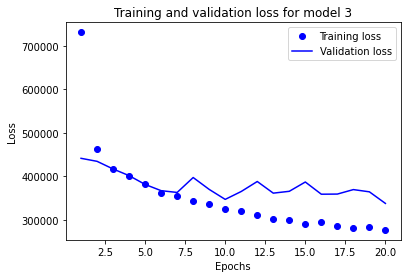

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model3.png', dpi=1200)

plt.show()

## Model 4

In [16]:
model = models.Sequential()
model.add(layers.Dense(8, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 288       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 1)                

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 2s 6ms/step - loss: 462500.4375 - mae: 508.7333 - val_loss: 509827.1250 - val_mae: 501.3854
Epoch 2/20
297/297 [==============================] - 2s 5ms/step - loss: 432433.0938 - mae: 499.0868 - val_loss: 512019.5938 - val_mae: 500.9638
Epoch 3/20
297/297 [==============================] - 2s 5ms/step - loss: 417807.4375 - mae: 496.2288 - val_loss: 526683.1875 - val_mae: 501.7972
Epoch 4/20
297/297 [==============================] - 2s 6ms/step - loss: 387621.4688 - mae: 477.8888 - val_loss: 516036.8438 - val_mae: 491.9915
Epoch 5/20
297/297 [==============================] - 2s 5ms/step - loss: 371810.3438 - mae: 466.4300 - val_loss: 486069.4688 - val_mae: 475.3908
Epoch 6/20
297/297 [==============================] - 2s 5ms/step - loss: 346291.2812 - mae: 450.3192 - val_loss: 473318.4062 - val_mae: 465.0431
Epoch 7/20
297/297 [==============================] - 2s 5ms/step - loss: 329517.3750 - mae: 432.5375 - val_loss: 421129.312

[449939.15625, 454.982177734375]

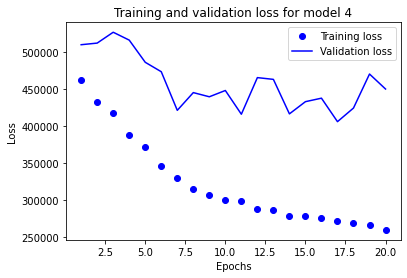

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model4.png', dpi=1200)

plt.show()

## Model 5

In [19]:
model = models.Sequential()
model.add(layers.Dense(16, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                576       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 6ms/step - loss: 517222.9688 - mae: 536.1293 - val_loss: 452278.0312 - val_mae: 484.8969
Epoch 2/20
297/297 [==============================] - 2s 5ms/step - loss: 409724.9688 - mae: 484.4326 - val_loss: 431146.3438 - val_mae: 457.4763
Epoch 3/20
297/297 [==============================] - 2s 5ms/step - loss: 367560.6562 - mae: 459.1902 - val_loss: 417352.1562 - val_mae: 444.1916
Epoch 4/20
297/297 [==============================] - 2s 6ms/step - loss: 342395.8438 - mae: 439.3727 - val_loss: 437748.6250 - val_mae: 448.8008
Epoch 5/20
297/297 [==============================] - 1s 5ms/step - loss: 318585.1250 - mae: 419.9056 - val_loss: 366555.8438 - val_mae: 415.8190
Epoch 6/20
297/297 [==============================] - 2s 5ms/step - loss: 305233.6250 - mae: 407.9542 - val_loss: 433410.6250 - val_mae: 452.2440
Epoch 7/20
297/297 [==============================] - 2s 5ms/step - loss: 300000.7500 - mae: 401.0567 - val_loss: 470436.843

[351408.5625, 399.2767333984375]

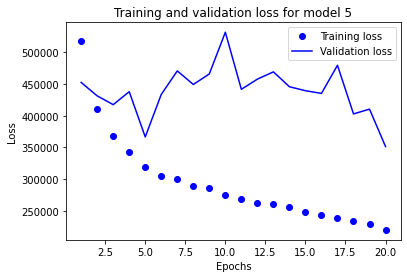

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model5.png', dpi=1200)

plt.show()

## Model 6

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                2304      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 7ms/step - loss: 478971.6875 - mae: 518.6257 - val_loss: 404856.8750 - val_mae: 482.2755
Epoch 2/20
297/297 [==============================] - 2s 5ms/step - loss: 409125.9375 - mae: 487.2763 - val_loss: 412143.3125 - val_mae: 442.8113
Epoch 3/20
297/297 [==============================] - 2s 6ms/step - loss: 349856.4062 - mae: 443.6528 - val_loss: 335871.1562 - val_mae: 409.4437
Epoch 4/20
297/297 [==============================] - 2s 5ms/step - loss: 333606.8125 - mae: 426.6975 - val_loss: 336424.4062 - val_mae: 404.0911
Epoch 5/20
297/297 [==============================] - 2s 5ms/step - loss: 309389.8125 - mae: 408.5814 - val_loss: 306686.2500 - val_mae: 386.9043
Epoch 6/20
297/297 [==============================] - 2s 5ms/step - loss: 294832.3438 - mae: 396.2332 - val_loss: 338767.3750 - val_mae: 398.4107
Epoch 7/20
297/297 [==============================] - 1s 5ms/step - loss: 288830.4688 - mae: 391.4121 - val_loss: 336235.000

[264963.4375, 336.58349609375]

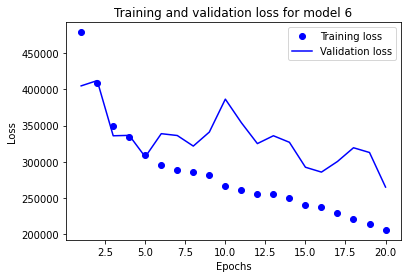

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 6')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model6.png', dpi=1200)

plt.show()

## Model 7

In [25]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                2304      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                1040      
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 dense_24 (Dense)            (None, 1)                

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 6ms/step - loss: 485188.8438 - mae: 524.7321 - val_loss: 409295.3750 - val_mae: 469.7590
Epoch 2/20
297/297 [==============================] - 2s 6ms/step - loss: 431582.8750 - mae: 493.1885 - val_loss: 333303.9375 - val_mae: 425.8589
Epoch 3/20
297/297 [==============================] - 2s 5ms/step - loss: 376703.6250 - mae: 456.2497 - val_loss: 326736.3438 - val_mae: 402.5748
Epoch 4/20
297/297 [==============================] - 2s 5ms/step - loss: 350302.2188 - mae: 433.9647 - val_loss: 299212.3125 - val_mae: 387.8101
Epoch 5/20
297/297 [==============================] - 2s 5ms/step - loss: 333293.2188 - mae: 416.8779 - val_loss: 277628.0312 - val_mae: 383.7771
Epoch 6/20
297/297 [==============================] - 2s 5ms/step - loss: 321857.1562 - mae: 407.9726 - val_loss: 289215.9375 - val_mae: 377.0053
Epoch 7/20
297/297 [==============================] - 1s 5ms/step - loss: 316930.1875 - mae: 401.9073 - val_loss: 314331.281

[158530.421875, 279.75128173828125]

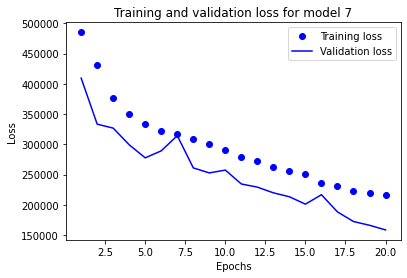

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 7')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model7.png', dpi=1200)

plt.show()

## Model 8

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                2304      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 8)                

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 3s 6ms/step - loss: 648032.6250 - mae: 595.1998 - val_loss: 456027.7188 - val_mae: 491.5452
Epoch 2/20
297/297 [==============================] - 1s 5ms/step - loss: 501850.4375 - mae: 530.0619 - val_loss: 390170.9688 - val_mae: 451.3433
Epoch 3/20
297/297 [==============================] - 2s 6ms/step - loss: 442515.4062 - mae: 489.9201 - val_loss: 359468.2188 - val_mae: 414.3210
Epoch 4/20
297/297 [==============================] - 2s 6ms/step - loss: 391275.4688 - mae: 453.6159 - val_loss: 320406.8750 - val_mae: 394.9715
Epoch 5/20
297/297 [==============================] - 2s 6ms/step - loss: 388270.1250 - mae: 446.7886 - val_loss: 318924.7812 - val_mae: 390.7517
Epoch 6/20
297/297 [==============================] - 2s 5ms/step - loss: 369820.4375 - mae: 433.5405 - val_loss: 302988.4375 - val_mae: 382.2283
Epoch 7/20
297/297 [==============================] - 2s 6ms/step - loss: 367614.7500 - mae: 426.3484 - val_loss: 311521.437

[156074.0, 273.14898681640625]

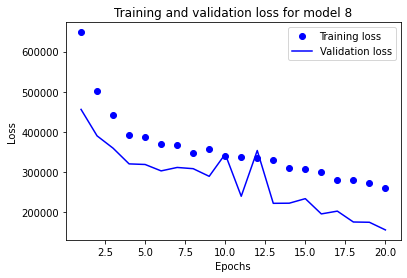

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 8')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model8.png', dpi=1200)

plt.show()

## Model 9

In [31]:
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               4608      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 16)               

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
297/297 [==============================] - 4s 8ms/step - loss: 698990.0625 - mae: 618.8202 - val_loss: 512931.9688 - val_mae: 503.7224
Epoch 2/20
297/297 [==============================] - 2s 7ms/step - loss: 606882.0000 - mae: 578.7545 - val_loss: 493327.9688 - val_mae: 478.2543
Epoch 3/20
297/297 [==============================] - 2s 7ms/step - loss: 542462.3750 - mae: 532.1305 - val_loss: 444382.8438 - val_mae: 449.4548
Epoch 4/20
297/297 [==============================] - 2s 7ms/step - loss: 500241.3125 - mae: 502.1732 - val_loss: 439514.6562 - val_mae: 448.1589
Epoch 5/20
297/297 [==============================] - 2s 7ms/step - loss: 484514.8125 - mae: 496.9810 - val_loss: 465335.6875 - val_mae: 462.7914
Epoch 6/20
297/297 [==============================] - 2s 7ms/step - loss: 474463.9688 - mae: 486.6562 - val_loss: 328124.1562 - val_mae: 393.8752
Epoch 7/20
297/297 [==============================] - 2s 8ms/step - loss: 466149.6875 - mae: 482.2459 - val_loss: 417726.375

[336688.78125, 386.3243713378906]

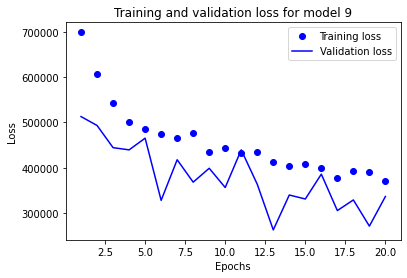

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 9')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model9.png', dpi=1200)

plt.show()

## Model 10

In [34]:
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 128)               4608      
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_40 (Dense)            (None, 16)               

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/20
198/198 [==============================] - 3s 7ms/step - loss: 545821.2500 - mae: 550.8256 - val_loss: 555971.8125 - val_mae: 515.4523
Epoch 2/20
198/198 [==============================] - 1s 6ms/step - loss: 472205.1875 - mae: 508.7600 - val_loss: 461106.0312 - val_mae: 462.0154
Epoch 3/20
198/198 [==============================] - 1s 6ms/step - loss: 430285.7188 - mae: 475.1423 - val_loss: 391857.5312 - val_mae: 424.6517
Epoch 4/20
198/198 [==============================] - 1s 6ms/step - loss: 405010.7188 - mae: 454.2548 - val_loss: 447898.9688 - val_mae: 454.7197
Epoch 5/20
198/198 [==============================] - 1s 6ms/step - loss: 384027.6875 - mae: 442.7126 - val_loss: 368292.0938 - val_mae: 411.4093
Epoch 6/20
198/198 [==============================] - 1s 7ms/step - loss: 389264.4062 - mae: 440.2032 - val_loss: 388731.5625 - val_mae: 420.7573
Epoch 7/20
198/198 [==============================] - 1s 7ms/step - loss: 356080.3125 - mae: 420.2407 - val_loss: 389433.437

[283992.0, 349.7229309082031]

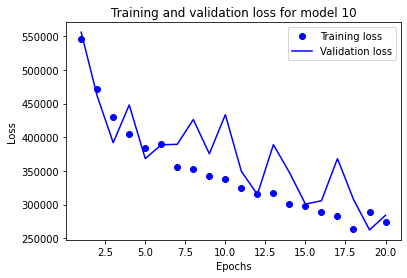

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model10.png', dpi=1200)

plt.show()

## Model 11 (Resetting to Model 8)

In [37]:
num_epochs = 50

In [38]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                2304      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 16)                528       
                                                                 
 dropout_36 (Dropout)        (None, 16)                0         
                                                                 
 dense_47 (Dense)            (None, 8)               

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=20, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/50
297/297 [==============================] - 3s 7ms/step - loss: 536171.0625 - mae: 543.7702 - val_loss: 462497.7188 - val_mae: 488.3777
Epoch 2/50
297/297 [==============================] - 2s 6ms/step - loss: 465286.1875 - mae: 509.5114 - val_loss: 407970.5312 - val_mae: 453.9545
Epoch 3/50
297/297 [==============================] - 2s 6ms/step - loss: 416646.1875 - mae: 474.9143 - val_loss: 321865.5000 - val_mae: 405.5491
Epoch 4/50
297/297 [==============================] - 2s 6ms/step - loss: 376902.6875 - mae: 445.2870 - val_loss: 286769.5312 - val_mae: 391.1877
Epoch 5/50
297/297 [==============================] - 2s 6ms/step - loss: 363109.1562 - mae: 430.4817 - val_loss: 338654.1875 - val_mae: 400.7421
Epoch 6/50
297/297 [==============================] - 2s 6ms/step - loss: 349778.8125 - mae: 421.9467 - val_loss: 288043.7188 - val_mae: 375.7428
Epoch 7/50
297/297 [==============================] - 2s 6ms/step - loss: 348811.5625 - mae: 418.6263 - val_loss: 274644.718

[175100.40625, 289.0185241699219]

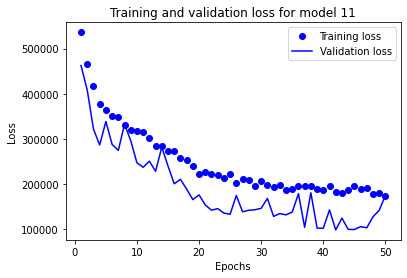

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 11')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model11.png', dpi=1200)

plt.show()

## Model 12

In [41]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 64)                2304      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 32)                2080      
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_51 (Dense)            (None, 16)                528       
                                                                 
 dropout_40 (Dropout)        (None, 16)                0         
                                                                 
 dense_52 (Dense)            (None, 8)               

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/50
198/198 [==============================] - 3s 8ms/step - loss: 502986.7188 - mae: 530.4130 - val_loss: 529012.0625 - val_mae: 507.7281
Epoch 2/50
198/198 [==============================] - 1s 6ms/step - loss: 463232.0625 - mae: 511.2747 - val_loss: 454801.7812 - val_mae: 471.3799
Epoch 3/50
198/198 [==============================] - 1s 6ms/step - loss: 421903.5000 - mae: 486.3158 - val_loss: 395784.7188 - val_mae: 434.4265
Epoch 4/50
198/198 [==============================] - 1s 6ms/step - loss: 376822.5000 - mae: 453.0859 - val_loss: 367222.9375 - val_mae: 415.8790
Epoch 5/50
198/198 [==============================] - 1s 6ms/step - loss: 364674.0625 - mae: 437.4708 - val_loss: 336318.0312 - val_mae: 400.6890
Epoch 6/50
198/198 [==============================] - 1s 6ms/step - loss: 340664.0312 - mae: 422.2834 - val_loss: 290081.7500 - val_mae: 381.1206
Epoch 7/50
198/198 [==============================] - 1s 5ms/step - loss: 327130.8125 - mae: 410.3238 - val_loss: 280878.125

[111622.09375, 223.2386016845703]

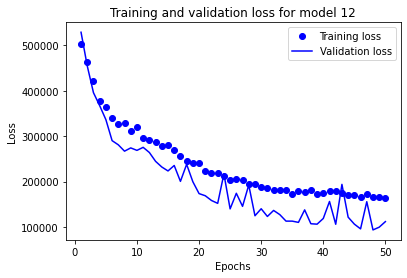

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 12')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model12.png', dpi=1200)

plt.show()

## Model 13

In [44]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 64)                2304      
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dropout_43 (Dropout)        (None, 32)                0         
                                                                 
 dense_56 (Dense)            (None, 16)                528       
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
                                                                 
 dense_57 (Dense)            (None, 8)               

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=100, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/50
60/60 [==============================] - 1s 9ms/step - loss: 1033864.1250 - mae: 774.5880 - val_loss: 747267.0000 - val_mae: 599.6160
Epoch 2/50
60/60 [==============================] - 0s 7ms/step - loss: 636818.8750 - mae: 587.7579 - val_loss: 511023.3750 - val_mae: 508.0387
Epoch 3/50
60/60 [==============================] - 0s 8ms/step - loss: 583080.1250 - mae: 567.7794 - val_loss: 488296.7812 - val_mae: 501.4037
Epoch 4/50
60/60 [==============================] - 0s 8ms/step - loss: 593719.2500 - mae: 571.9290 - val_loss: 500491.5000 - val_mae: 502.1988
Epoch 5/50
60/60 [==============================] - 0s 7ms/step - loss: 553641.6250 - mae: 558.8150 - val_loss: 478939.8125 - val_mae: 495.4332
Epoch 6/50
60/60 [==============================] - 1s 9ms/step - loss: 548179.2500 - mae: 554.2318 - val_loss: 453642.3438 - val_mae: 487.7926
Epoch 7/50
60/60 [==============================] - 0s 6ms/step - loss: 541222.9375 - mae: 547.9458 - val_loss: 451127.8750 - val_mae: 

[276990.21875, 348.5786437988281]

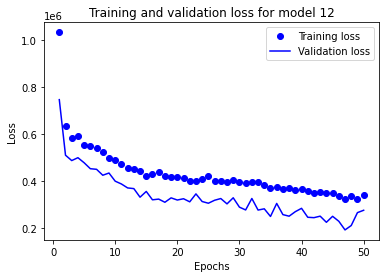

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 12')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model13.png', dpi=1200)

plt.show()

## Model 14 (Back to Model 12)

In [47]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],), kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 64)                2304      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dropout_47 (Dropout)        (None, 32)                0         
                                                                 
 dense_61 (Dense)            (None, 16)                528       
                                                                 
 dropout_48 (Dropout)        (None, 16)                0         
                                                                 
 dense_62 (Dense)            (None, 8)               

In [48]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/50
198/198 [==============================] - 3s 9ms/step - loss: 524242.8125 - mae: 534.7256 - val_loss: 452900.6250 - val_mae: 491.8577
Epoch 2/50
198/198 [==============================] - 2s 8ms/step - loss: 455816.2188 - mae: 508.2737 - val_loss: 456412.9375 - val_mae: 478.3953
Epoch 3/50
198/198 [==============================] - 1s 7ms/step - loss: 414356.3438 - mae: 482.8826 - val_loss: 385936.5312 - val_mae: 444.4756
Epoch 4/50
198/198 [==============================] - 1s 7ms/step - loss: 372267.2500 - mae: 453.0904 - val_loss: 343412.1875 - val_mae: 411.7552
Epoch 5/50
198/198 [==============================] - 1s 7ms/step - loss: 353753.9062 - mae: 433.0651 - val_loss: 319507.5312 - val_mae: 396.3330
Epoch 6/50
198/198 [==============================] - 2s 8ms/step - loss: 340200.6875 - mae: 420.5892 - val_loss: 329932.9375 - val_mae: 398.1161
Epoch 7/50
198/198 [==============================] - 1s 8ms/step - loss: 332571.7188 - mae: 415.5874 - val_loss: 295382.000

[115543.671875, 225.08506774902344]

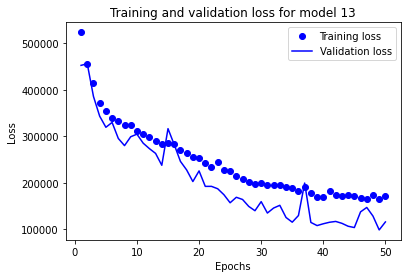

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 13')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model14.png', dpi=1200)

plt.show()

## Model 15 (Reset to Model 12)

In [50]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                2304      
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 32)                2080      
                                                                 
 dropout_51 (Dropout)        (None, 32)                0         
                                                                 
 dense_66 (Dense)            (None, 16)                528       
                                                                 
 dropout_52 (Dropout)        (None, 16)                0         
                                                                 
 dense_67 (Dense)            (None, 8)               

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=40, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/50
149/149 [==============================] - 2s 7ms/step - loss: 589494.7500 - mae: 570.1854 - val_loss: 481222.1562 - val_mae: 496.4099
Epoch 2/50
149/149 [==============================] - 1s 5ms/step - loss: 503506.2812 - mae: 525.9610 - val_loss: 431565.5000 - val_mae: 476.8543
Epoch 3/50
149/149 [==============================] - 1s 5ms/step - loss: 459522.4688 - mae: 503.7439 - val_loss: 393239.5312 - val_mae: 448.6257
Epoch 4/50
149/149 [==============================] - 1s 6ms/step - loss: 419238.0000 - mae: 480.0449 - val_loss: 349337.5938 - val_mae: 416.2205
Epoch 5/50
149/149 [==============================] - 1s 5ms/step - loss: 405411.9688 - mae: 461.4094 - val_loss: 323213.0625 - val_mae: 401.3758
Epoch 6/50
149/149 [==============================] - 1s 6ms/step - loss: 369679.9062 - mae: 436.0445 - val_loss: 307078.4375 - val_mae: 392.3344
Epoch 7/50
149/149 [==============================] - 1s 6ms/step - loss: 366972.6875 - mae: 436.2617 - val_loss: 302177.750

[103161.984375, 219.40672302246094]

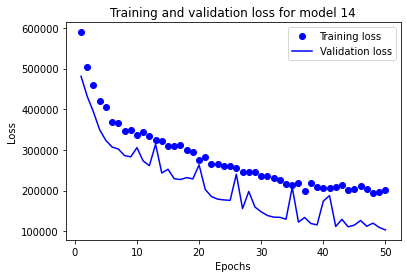

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 14')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model15.png', dpi=1200)

plt.show()

## Model 16 (Reset to Model 12)

In [53]:
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 64)                2304      
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dropout_55 (Dropout)        (None, 32)                0         
                                                                 
 dense_71 (Dense)            (None, 16)                528       
                                                                 
 dropout_56 (Dropout)        (None, 16)                0         
                                                                 
 dense_72 (Dense)            (None, 8)               

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])
model.evaluate(X_test, y_test)

Epoch 1/50
198/198 [==============================] - 3s 8ms/step - loss: 662306.1875 - mae: 596.6657 - val_loss: 534571.1250 - val_mae: 508.7713
Epoch 2/50
198/198 [==============================] - 1s 6ms/step - loss: 519835.4062 - mae: 533.7463 - val_loss: 451781.4062 - val_mae: 475.1609
Epoch 3/50
198/198 [==============================] - 1s 7ms/step - loss: 491928.8125 - mae: 516.2905 - val_loss: 413670.6875 - val_mae: 447.9720
Epoch 4/50
198/198 [==============================] - 1s 6ms/step - loss: 444015.8125 - mae: 485.3120 - val_loss: 321398.1562 - val_mae: 415.2010
Epoch 5/50
198/198 [==============================] - 1s 6ms/step - loss: 424478.3438 - mae: 471.4962 - val_loss: 346978.2812 - val_mae: 408.4313
Epoch 6/50
198/198 [==============================] - 1s 7ms/step - loss: 423242.8750 - mae: 464.2615 - val_loss: 340319.0000 - val_mae: 402.5390
Epoch 7/50
198/198 [==============================] - 1s 6ms/step - loss: 410223.1250 - mae: 454.9538 - val_loss: 388341.093

[215785.90625, 306.1164245605469]

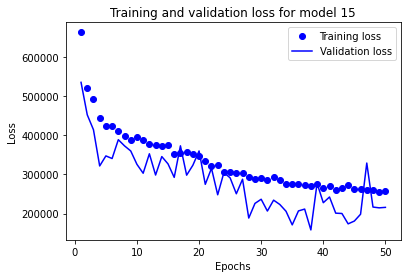

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for model 15')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('images/model16.png', dpi=1200)

plt.show()

## Plotting Predicted vs Actual values using Model 12

In [56]:
# recreate model 12
model = models.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2, seed=22))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 64)                2304      
                                                                 
 dropout_59 (Dropout)        (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dropout_60 (Dropout)        (None, 32)                0         
                                                                 
 dense_77 (Dense)            (None, 16)                528       
                                                                 
 dropout_61 (Dropout)        (None, 16)                0         
                                                                 
 dense_78 (Dense)            (None, 8)               

In [57]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(
    X_test, y_test), batch_size=30, verbose=True, callbacks=[tensorboard_callback])

Epoch 1/50
198/198 [==============================] - 2s 7ms/step - loss: 605189.6250 - mae: 578.9824 - val_loss: 451982.0000 - val_mae: 490.3232
Epoch 2/50
198/198 [==============================] - 1s 6ms/step - loss: 505331.3750 - mae: 528.8753 - val_loss: 393630.3750 - val_mae: 458.4974
Epoch 3/50
198/198 [==============================] - 1s 6ms/step - loss: 420094.1875 - mae: 480.1106 - val_loss: 359641.7188 - val_mae: 416.2064
Epoch 4/50
198/198 [==============================] - 1s 6ms/step - loss: 384125.0312 - mae: 451.6011 - val_loss: 301691.9375 - val_mae: 400.2227
Epoch 5/50
198/198 [==============================] - 1s 6ms/step - loss: 362663.2812 - mae: 430.5607 - val_loss: 310072.2500 - val_mae: 389.9933
Epoch 6/50
198/198 [==============================] - 1s 6ms/step - loss: 351339.4375 - mae: 427.0841 - val_loss: 294988.4375 - val_mae: 381.7038
Epoch 7/50
198/198 [==============================] - 1s 5ms/step - loss: 344589.4375 - mae: 421.5572 - val_loss: 293261.531

In [58]:
prediction = model.predict(X_test, batch_size=30, verbose=True)
model.evaluate(X_test,y_test)

80/80 [==============================] - 0s 2ms/step - loss: 114775.3594 - mae: 223.8007


[114775.359375, 223.8007354736328]

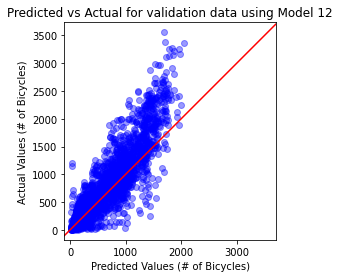

In [59]:
plt.plot(prediction, y_test, 'bo', alpha = 0.4)
plt.axline((0,0), slope=1, color='red')
plt.title('Predicted vs Actual for validation data using Model 12')
plt.xlabel('Predicted Values (# of Bicycles)')
plt.ylabel('Actual Values (# of Bicycles)')
plt.xlim(right=3700)
plt.gca().set_aspect(1.0)

plt.savefig('images/predictactual.png', dpi=1200)

plt.show()

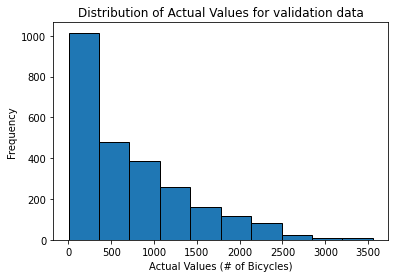

In [60]:
plt.hist(y_test, ec="black")
plt.title('Distribution of Actual Values for validation data')
plt.xlabel('Actual Values (# of Bicycles)')
plt.ylabel('Frequency')

plt.savefig('images/histo.png', dpi=1200)

plt.show()

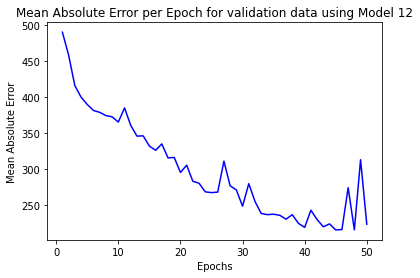

In [63]:
val_mae = history.history['val_mae']

epochs = range(1, len(val_mae) + 1)

plt.plot(epochs, val_mae, 'b')
plt.title('Mean Absolute Error per Epoch for validation data using Model 12')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

plt.savefig('images/mae.png', dpi=1200)

plt.show()